# Switch / Light example


### concept system modeling according to literature

based on TNO report: Guided root analysis of machine failure, par 5.2

a system is an assembly of components + connections between components

how to define a component?
- define inputs and outputs
- define failure modes
- inputs and outputs are associated with modalities and a modality has properties
- relation between inputs and outputs for normal behavior and for every failure mode

how to define an assembly
- components that are part of the assembly
- how the components are connected

limitations/prerequisites system modeling
- every component has one health and one output variable. multiple inputs are possible
- type names are unique
- variable names are unique and follow strict convention PropertyModalityInputsName

### generate influence diagram from system definition

implementation below uses following steps
- define component (inputs/outputs, ...) as dict
- define connection as dict
- define system as dict
- create diagram
  - generate nodes from dicts and add to influence diagram
  - generate arcs from dict and add to influence diagram

### component specification

- every component has one or more inputs, outputs
- every component has one health
- every component has a type
- inputs/outputs/health have modalities which have properties which have values

probabilities
- health and inputs don't have parents, prior can be determined before hand
- 

In [460]:
# component Switch > Python datastructure dictionary

switch = {
    "type":"Switch",
    "Inputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"],
            "normal1":"yes",
            "normal2":"*",
            "failure1":"no"
        },
        "2":
        {
            "modality":"State",
            "property":"Enabled",
            "propertyvalues":["yes", "no"]
        }
    },
    "Outputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"],
            "priorprobability":[0.99,0.01]
        }
    },
    "Behavior":{
        "normal": {
            'PresentPowerInputs':  ["yes", "yes","no"], 
            'EnabledStateInputs':  ["yes", "yes","no"],
            'PresentPowerOutputs': ["yes", "yes","no"]
        }
    }
}

In [343]:
# component Light > Python datastructure dictionary

light = {
    "type":"Light",
    "Inputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Outputs":{
        "1":{
            "modality":"Light",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"],
            "priorprobability":[0.9,0.1]
        }
    }
}

### connections connect components 
- connections have a name
- connections have two named components and a direction
- connections have a health that is connected to the component that is addressed by the connection

In [344]:
wire = {
    "type":"Wire",
    "start":"PresentPowerOutputs",
    "typeStart":"Switch",
    "end":"PresentPowerInputs",
    "typeEnd":"Light",
    "healthpriorprobability":0.99
}

### system defines assembly
system consists of components and connections between them

In [345]:
structure = {
    "components": {
        "1":{
            "name":"Light",
            "type":"Light"
        },
        "2":{
            "name":"Switch",
            "type":"Switch"           
        }
    },
    "connections":{
        "1":{
            "name":"Wire",
            "type":"Wire",
            "startComponent":"Switch",
            "endComponent":"Light"
        }
    }
}

structure2 = {
    "components": {
        "1":{
            "name":"Switch",
            "type":"Switch"           
        }
    }
}

In [346]:
# create "system"
#components = [switch, light]
components = [switch]
#connections = [wire]
connections = []
assembly = {
    "components" : components,
    "connections": connections,
    "structure":structure2
}

In [347]:
# imports
import os
import matplotlib.pyplot as plt
from pylab import *
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from IPython.display import display,HTML
import re

# structure

In [348]:
# purpose: add Components from system structure to diagram

# diag: pyagrum influence diagram
# comp: specification of 1 component
# name: name to use for component in diagram

# result: nodes for 1 component added to diagram

# per modality a variable is generated and added to diagram
# arcs are created to connect inputs to output and health to output

def addComponentToDiagram(diag, comp, name):
    componentkeys = ["Inputs","Outputs","Healths"]
    keys = comp.keys()
    labels = []
        
    # read inputs, outputs and health, add named variable to diagram 
    for ckey in componentkeys:
        if ckey in keys:  
            for modality in comp[ckey].keys():                                             # get modalities
                modalitylabel = comp[ckey][modality]["modality"]                           # get modality label
                property = comp[ckey][modality]["property"]                                # get property label
                propertyvalues = comp[ckey][modality]["propertyvalues"]                    # get property values
                if(ckey == "Healths"):                                                     # shorter name for health
                    label = str(property + name)
                else:
                    label = str(property + modalitylabel + ckey + name)                    # name variable
                labels.append(label)
                diag.addChanceNode(gum.LabelizedVariable(label, label, propertyvalues))    # add variable to diagram

    # add arcs to connect inputs / health nodes to output within component
    inputvars = []
    for label in labels:
        if(re.search("Inputs", label)):
            inputvars.append(diag.idFromName(label))
        if(re.search("health", label)):
            hvar = diag.idFromName(label)
        if(re.search("Outputs",label)):
            ovar = diag.idFromName(label)
    # add arc for health to output
    diag.addArc(hvar, ovar)
    # add arc for every input to output
    for v in inputvars:
        diag.addArc(v,ovar)        

In [349]:
# purpose: read connection specification and connect components in diagram via arc, 
# create health for connection

# diag: pyagrum influence diagram
# name: name to use for connection in diagram
# connection: type of connection used to find right specification for connection
# startComponent: component from which the connection starts
# endComponent: component that receives connection

# result: connection + health for connection created in diagram

def addConnectionToDiagram(diag, name, connection, startComponent, endComponent):
    diaglabels = diag.names()
    for label in diaglabels:
        if(re.search(startComponent, label)):
            if(re.search(connection['start'], label)):
                startvar = diag.idFromName(label)
        elif(re.search(endComponent, label)):
            if(re.search(connection['end'], label)):
                endvar = diag.idFromName(label)
    diag.addArc(startvar, endvar)
    label = str("health" + name)
    hvar = diag.addChanceNode(gum.LabelizedVariable(label,label,["ok","broken"]))
    diag.addArc(hvar, endvar)

In [350]:
# find the right dict in set of elements (components or connections) by searching typename
def getDictByType(elementType, elementSet):
    for c in elementSet:
        if(c["type"] == elementType):
            return c
        else:print("error getDictByType: no dict found for type")

In [351]:
# disassemble system, read systemstructure and add components + connections to diagram
def buildDiagram(diag, assembly):
    systemstructure = assembly["structure"]
    components = assembly["components"]
    connections = assembly["connections"]

    # loop sets (connections, components) in assembly structure
    for set, elements in systemstructure.items():

        # add components from structure to diagram
        if(set =="components"):
            for n, value in elements.items():
                addComponentToDiagram(diag, getDictByType(value["type"], components) ,value['name'])

        #add connections from structure to diagram
        if(set =="connections"):
            for n, connection in elements.items():
                connectionType = getDictByType(connection["type"], connections)
                startComponent = connection["startComponent"]
                endComponent = connection["endComponent"]
                connectionName = connection["name"]
                addConnectionToDiagram(diag,connectionName, connectionType, startComponent, endComponent)


Influence Diagram{
  chance: 4,
  utility: 0,
  decision: 0,
  arcs: 3,
  domainSize: 16
}


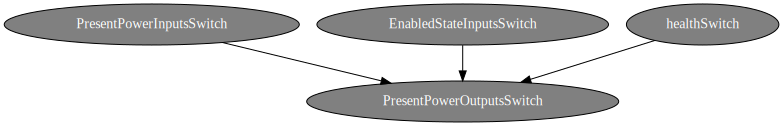

In [352]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# create diagram
diagram = gum.InfluenceDiagram()

# read structure, add to diagram
buildDiagram(diagram, assembly)

# print summary of nodes
print(diagram)

# view structure
gnb.showInfluenceDiagram(diagram, size=60)

# probabilities

todo's:

- determine components in diagram: switch, switch1 etc

Health en Inputs
- set priors van health, dit zijn altijd nodes zonder parent
- set priors van inputs, dit zijn ook nodes zonder parent, alternatieven:
  - eigen prior
  - afleiden uit behaviorstates, kans is 1 -/- failurekansen
  - een setting "expected"

Outputs
- behaviorstates definieren wat normaal is of niet voor hele component, de relatie tussen input / health en output is deterministic en dus 0 of 1, zie par 5.2.3
bijv normal1 voor switch is power in yes / enabled yes > power uit yes
- indien broken dan kans op NO is 1
- indien switch uit dan kans op NO is 1

connecties
- hoe doe je dat bij connecties, de input krijgt er een parent en een health bij

 

In [469]:
# determine ids in diagram for named component in diagram
def getIdsForName(name):
    ids = []
    for n in diagram.names():
        if (re.search(v["name"], n)):
            ids.append(diagram.idFromName(n))
    return ids

def setCPTHealthNode(i, typedict):
    pass


def setCPTInputsNode(i, typedict):
    pass

def setCPTOutputsNode(i, typedict):

#TODOTODO
# maak tabel vanuit key behavior voor normaal gedrag conform artikel is te specificeren
# loop door id's met loopIn()
# maak dan dict aan
# check of dict voorkomt in normaal tabel 
# zo ja: 1, diagram.cpt(id).set(instantiation,value)
# anders 0


   
    
    for name in diagram.cpt(i).names:
        print(name)
        for k, nstate in switch["Behavior"]['normal'].items():
            print(k)
            print(nstate)
       
        
#        for m in ["Inputs", "Outputs", "Healths"]:
#            for k, v in switch99[m].items():
#                print(v["modality"] + v["property"] + m + ":" + v[nstate])
     
#    diagram.cpt(i).fillWith(cptlist)
#    print(diagram.cpt(i))



#    cptlist = [1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0]

    
   
    



In [470]:
for k, v in assembly["structure"]["components"].items():
    ids = getIdsForName(v["name"])
    typedict = getDictByType(v["type"],assembly["components"])
    for i in ids:
        if (diagram.isChanceNode(i)):
            if re.search("health", diagram.variable(i).name()):
                setCPTHealthNode(i, typedict)
            elif re.search("Inputs", diagram.variable(i).name()):
                setCPTInputsNode(i, typedict)
            elif re.search("Outputs", diagram.variable(i).name()):
                setCPTOutputsNode(i, typedict)


PresentPowerOutputsSwitch
PresentPowerInputs
['yes', 'yes', 'no']
EnabledStateInputs
['yes', 'yes', 'no']
PresentPowerOutputs
['yes', 'yes', 'no']
healthSwitch
PresentPowerInputs
['yes', 'yes', 'no']
EnabledStateInputs
['yes', 'yes', 'no']
PresentPowerOutputs
['yes', 'yes', 'no']
PresentPowerInputsSwitch
PresentPowerInputs
['yes', 'yes', 'no']
EnabledStateInputs
['yes', 'yes', 'no']
PresentPowerOutputs
['yes', 'yes', 'no']
EnabledStateInputsSwitch
PresentPowerInputs
['yes', 'yes', 'no']
EnabledStateInputs
['yes', 'yes', 'no']
PresentPowerOutputs
['yes', 'yes', 'no']


In [409]:
diagram.cpt(2)

(pyAgrum.Potential<double>@0x2035db10) 
                    ||  PresentPowerOutpu|
health|Presen|Enable||yes      |no       |
------|------|------||---------|---------|
ok    |yes   |yes   || 0.0000  | 0.0000  |
broken|yes   |yes   || 0.0000  | 0.0000  |
ok    |no    |yes   || 0.0000  | 0.0000  |
broken|no    |yes   || 0.0000  | 0.0000  |
ok    |yes   |no    || 0.0000  | 0.0000  |
broken|yes   |no    || 0.0000  | 0.0000  |
ok    |no    |no    || 0.0000  | 0.0000  |
broken|no    |no    || 0.0000  | 0.0000  |

In [492]:
diagram.cpt(2)

(pyAgrum.Potential<double>@0x2035db10) 
                    ||  PresentPowerOutpu|
health|Presen|Enable||yes      |no       |
------|------|------||---------|---------|
ok    |yes   |yes   || 2.0000  | 2.0000  |
broken|yes   |yes   || 1.0000  | 1.0000  |
ok    |no    |yes   || 2.0000  | 2.0000  |
broken|no    |yes   || 0.0000  | 0.0000  |
ok    |yes   |no    || 2.0000  | 2.0000  |
broken|yes   |no    || 1.0000  | 1.0000  |
ok    |no    |no    || 2.0000  | 2.0000  |
broken|no    |no    || 0.0000  | 0.0000  |

In [491]:
for i in diagram.cpt(2).loopIn():
#    print(i)
    if(i.todict()["healthSwitch"] == "ok"):
        diagram.cpt(2).set(i,2)

In [403]:
probabilities = {
"PresentPowerInputsLight:yes|PresentPowerOutputsSwitch:yes|healthWire:ok":0.2,
"PresentPowerInputsLight:no|PresentPowerOutputsSwitch:yes|healthWire:ok":0.3,
"PresentPowerInputsLight:yes|PresentPowerOutputsSwitch:no|healthWire:ok":0.4,
"PresentPowerInputsLight:no|PresentPowerOutputsSwitch:no|healthWire:ok":0.5,
"PresentPowerInputsLight:yes|PresentPowerOutputsSwitch:yes|healthWire:broken":0.6,
"PresentPowerInputsLight:no|PresentPowerOutputsSwitch:yes|healthWire:broken":0.7,
"PresentPowerInputsLight:yes|PresentPowerOutputsSwitch:no|healthWire:broken":0.8,
"PresentPowerInputsLight:no|PresentPowerOutputsSwitch:no|healthWire:broken":0.9
}

probabilities2 = {
    "order": ("PresentPowerInputsLight", "PresentPowerOutputsSwitch", "healthWire"),
    "yes:yes:ok":0.9,
    "no:yes:ok":0.8,
    "yes:no:ok":0.7,
    "no:no:ok":0.6,
    "yes:yes:broken":0.5,
    "no:yes:broken":0.4,
    "yes:no:broken":0.3,
    "no:no:broken":0.2
}

In [471]:
id1 = diagram.idFromName("PresentPowerInputsLight")
for i in diagram.cpt(id1).loopIn():
    d = i.todict()
    s = ""
    for k, v in d.items():
        s = s + k + ":" + v + "|"
    c = probabilities[s[:-1]]
    diagram.cpt(id1).set(i,c)
diagram.cpt(id1)
    

NotFound: [pyAgrum] Object not found: No element with the key <PresentPowerInputsLight>

In [259]:
id1 = diagram.idFromName("PresentPowerInputsLight")
names = diagram.cpt(id1).names
cptlist = []
if (names == probabilities2["order"]):
    for k, v in probabilities2.items():
        if (k != "order"):
            cptlist.append(v)
diagram.cpt(id1).fillWith(cptlist)
diagram.cpt(id1)
            




(pyAgrum.Potential<double>@0x1fc22cb0) 
             ||  PresentPowerInput|
Presen|health||yes      |no       |
------|------||---------|---------|
yes   |ok    || 0.9000  | 0.8000  |
no    |ok    || 0.7000  | 0.6000  |
yes   |broken|| 0.5000  | 0.4000  |
no    |broken|| 0.3000  | 0.2000  |

In [193]:
labvar = gum.LabelizedVariable("healthWire", "healthWire",["ok","broken"])

In [200]:
i = gum.Instantiation()
i.add(labvar)
i.fromdict({'healthWire': 'ok'})
print(i)

<healthWire:ok>


In [201]:
diagram.cpt(id1).get(i)

InvalidArgument: [pyAgrum] Invalid argument: healthWire not present in the instantiation <healthWire:ok>

In [198]:
l = []

for i in diagram.cpt(id1).loopIn():
#    print(i)
    l.append(i)
    
l[0].todict()

{'healthWire': 'ok'}

In [113]:
values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.11,0.12,0.13,0.14,0.15,0.16,0.17]
diagram.cpt(id1).names


('PresentPowerOutputsSwitch',
 'healthSwitch',
 'PresentPowerInputsSwitch',
 'EnabledStateInputsSwitch')

In [114]:
diagram.cpt(id1).fillWith(values)

(pyAgrum.Potential<double>@0x1fbe0140) 
                    ||  PresentPowerOutpu|
health|Presen|Enable||yes      |no       |
------|------|------||---------|---------|
ok    |yes   |yes   || 0.1000  | 0.2000  |
broken|yes   |yes   || 0.3000  | 0.4000  |
ok    |no    |yes   || 0.5000  | 0.6000  |
broken|no    |yes   || 0.7000  | 0.8000  |
ok    |yes   |no    || 0.9000  | 0.1100  |
broken|yes   |no    || 0.1200  | 0.1300  |
ok    |no    |no    || 0.1400  | 0.1500  |
broken|no    |no    || 0.1600  | 0.1700  |

In [119]:
a = gum.RangeVariable("A","variable A", 1, 3)
b = gum.RangeVariable("B","variable B", 1, 2)
c = gum.RangeVariable("C","variable C", 1, 2)

p = gum.Potential().add(a).add(b).add(c).fillWith([1,2,3,4,5,6,7,8,9,10,11,12])
print(p)


             ||  A                          |
B     |C     ||1        |2        |3        |
------|------||---------|---------|---------|
1     |1     || 1.0000  | 2.0000  | 3.0000  |
2     |1     || 4.0000  | 5.0000  | 6.0000  |
1     |2     || 7.0000  | 8.0000  | 9.0000  |
2     |2     || 10.0000 | 11.0000 | 12.0000 |



In [149]:
for i in p.loopIn():
    print(type(i))

<class 'pyAgrum.pyAgrum.Instantiation'>
<class 'pyAgrum.pyAgrum.Instantiation'>
<class 'pyAgrum.pyAgrum.Instantiation'>
<class 'pyAgrum.pyAgrum.Instantiation'>
<class 'pyAgrum.pyAgrum.Instantiation'>
<class 'pyAgrum.pyAgrum.Instantiation'>
<class 'pyAgrum.pyAgrum.Instantiation'>
<class 'pyAgrum.pyAgrum.Instantiation'>
<class 'pyAgrum.pyAgrum.Instantiation'>
<class 'pyAgrum.pyAgrum.Instantiation'>
<class 'pyAgrum.pyAgrum.Instantiation'>
<class 'pyAgrum.pyAgrum.Instantiation'>


In [459]:
switch99 = {
    "type":"Switch",
    "Inputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"],
            "normal1":"yes",
            "normal2":"*",
            "failure1":"no"
        },
        "2":
        {
            "modality":"State",
            "property":"Enabled",
            "propertyvalues":["yes", "no"]
        }
    },
    "Outputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"],
            "priorprobability":[0.99,0.01]
        }
    },
    "Behavior":{
        "normal": {
            'PresentPowerInputs':  ["yes", "yes","no"], 
            'EnabledStateInputs':  ["yes", "yes","no"],
            'PresentPowerOutputs': ["yes", "yes","no"]
        }
    }
}